In [68]:
import sys
import os

project_root = os.path.abspath(os.path.join('..', '..', '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from cyberattacks_detection.models import RBFNN, ELM, ModelWrapper, min_max_scale, reverse_min_max_scale
from sklearn.linear_model import LinearRegression
import mlflow
import pickle
import pandas as pd
import re
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np

In [69]:
mlflow.set_tracking_uri("http://localhost:5000")

In [123]:
save_mode = True

In [71]:
model_path = "../../saved_models/"

# Load and save

## LR

In [ ]:
lr1 = mlflow.sklearn.load_model("runs:/40fd937e12c944f7a8f73bfdac4fb211/LR")
lr2 = mlflow.sklearn.load_model("runs:/a785405966314d1ea144b8f7cf93aa2b/LR")
lr3 = mlflow.sklearn.load_model("runs:/e64ab1056f4042b08dc1f81c3f22715a/LR")
lr4 = mlflow.sklearn.load_model("runs:/a413b8236b92444983890491c3ff27e3/LR")

In [73]:
if save_mode:
    pickle.dump(lr1, open(os.path.join(model_path, "lr_x1.sav"), 'wb'))
    pickle.dump(lr2, open(os.path.join(model_path, "lr_x2.sav"), 'wb'))
    pickle.dump(lr3, open(os.path.join(model_path, "lr_x3.sav"), 'wb'))
    pickle.dump(lr4, open(os.path.join(model_path, "lr_x4.sav"), 'wb'))

## RBFNN

In [147]:
# rbf_nn1 = mlflow.pyfunc.load_model("runs:/8181d8d7493e413f8d0df5b88f96502d/RBF")
rbf_nn1 = mlflow.pyfunc.load_model("runs:/a828580a01cc434a806d8ae93b51143b/RBF")
rbf_nn1 = rbf_nn1.unwrap_python_model().model
rbf_nn2 = mlflow.pyfunc.load_model("runs:/6050148659024e499f290453a2886f23/RBF")
rbf_nn2 = rbf_nn2.unwrap_python_model().model
rbf_nn3 = mlflow.pyfunc.load_model("runs:/42868971cfc34849909b3cbe0d376b60/RBF")
rbf_nn3 = rbf_nn3.unwrap_python_model().model
rbf_nn4 = mlflow.pyfunc.load_model("runs:/b01943d01d014a29871af1f14b863906/RBF")
rbf_nn4 = rbf_nn4.unwrap_python_model().model

In [ ]:
print(rbf_nn1.feature_names_in_)
print(rbf_nn2.feature_names_in_)
print(rbf_nn3.feature_names_in_)
print(rbf_nn4.feature_names_in_)

In [152]:
if save_mode: 
    rbf_nn1.save_model(os.path.join(model_path, "rbf_x1.npz"))
    rbf_nn2.save_model(os.path.join(model_path, "rbf_x2.npz"))
    rbf_nn3.save_model(os.path.join(model_path, "rbf_x3.npz"))
    rbf_nn4.save_model(os.path.join(model_path, "rbf_x4.npz"))
    print("saved all models")

saved all models


## ELM

In [127]:
elm1 = mlflow.pyfunc.load_model("runs:/dcfabfbdc2484d139dcb02f0690792ac/ELM")
elm1 = elm1.unwrap_python_model().model
elm2 = mlflow.pyfunc.load_model("runs:/e39e3fdcffb744fb9ad64a632251984f/ELM")
elm2 = elm2.unwrap_python_model().model
elm3 = mlflow.pyfunc.load_model("runs:/2869d86018284fc3a9f7672a4a617eb3/ELM")
elm3 = elm3.unwrap_python_model().model
elm4 = mlflow.pyfunc.load_model("runs:/31910ec846ee4f058995e18ca5b410bd/ELM")
elm4 = elm4.unwrap_python_model().model

In [128]:
print(elm1.feature_names_in_)
print(elm2.feature_names_in_)
print(elm3.feature_names_in_)
print(elm4.feature_names_in_)

Index(['q_A(k-1)', 'q_B(k-1)', 'x2(k-1)', 'x3(k-1)', 'x4(k-1)', 'x1(k-1)'], dtype='object')
Index(['q_A(k-1)', 'q_B(k-1)', 'x1(k-1)', 'x3(k-1)', 'x4(k-1)', 'x2(k-1)'], dtype='object')
Index(['q_A(k-1)', 'q_B(k-1)', 'x3(k-1)'], dtype='object')
Index(['q_A(k-1)', 'q_B(k-1)', 'x4(k-1)'], dtype='object')


In [129]:
if save_mode:
    elm1.save_model(os.path.join(model_path, "elm_x1.npz"))
    elm2.save_model(os.path.join(model_path, "elm_x2.npz"))
    elm3.save_model(os.path.join(model_path, "elm_x3.npz"))
    elm4.save_model(os.path.join(model_path, "elm_x4.npz"))

# Validate

## Prepare data

In [82]:
data_path = "../../data/four_tanks/"

In [83]:
# dane bez zakłóceń
df_train = pd.read_csv(data_path+"result_ol_without_noise_uczące_v3.csv", sep=';', index_col=0)
df_val = pd.read_csv(data_path+"result_ol_without_noise_walidacyjne_v3.csv", sep=';', index_col=0)
df_test = pd.read_csv(data_path+"result_ol_without_noise_testowe_v3.csv", sep=';', index_col=0)
dataset_name = "bez zakłóceń"

In [84]:
# # dane z zakłóceniami
# df_train = pd.read_csv(data_path+"result_ol_with_noise_uczące_v3.csv", sep=';', index_col=0)
# df_val = pd.read_csv(data_path+"result_ol_with_noise_walidacyjne_v3.csv", sep=';', index_col=0)
# df_test = pd.read_csv(data_path+"result_ol_with_noise_testowe_v3.csv", sep=';', index_col=0)
# dataset_name = "z zakłóceniami"

In [85]:
df_train.head()

,q_A [cm^3/s],q_B [cm^3/s],q_d1 [cm^3/s],q_d2 [cm^3/s],q_d3 [cm^3/s],q_d4 [cm^3/s],x1 [cm],x2 [cm],x3 [cm],x4 [cm]
0,452.78,555.56,0.0,0.0,0.0,0.0,65.000000,66.000000,65.000000,66.000000
1,452.78,555.56,0.0,0.0,-0.0,0.0,64.984326,65.937304,65.038198,65.992639
2,452.78,555.56,0.0,-0.0,0.0,-0.0,64.971213,65.878615,65.074774,65.985573
3,452.78,555.56,0.0,0.0,-0.0,-0.0,64.960438,65.823672,65.109799,65.978790
4,452.78,555.56,0.0,-0.0,0.0,-0.0,64.951795,65.772231,65.143339,65.972278


In [86]:
def transform_column_name(df):
    df.columns = [col[0] for col in df.columns.str.split()]
    return df

In [87]:
df_train = transform_column_name(df_train)
df_val = transform_column_name(df_val)
df_test = transform_column_name(df_test)

In [88]:
qa_max = round(3260000/3600, 2)
qa_min=0
qb_max = round(4000000/3600)
qb_min=0
x_max = [136,
         136,
         130,
         130]
x_min = [20,
         20,
         20,
         20]

In [89]:
def add_delay(df, col, steps=1):    
    df[col+f'(k-{steps})'] = df[col].shift(steps)
    return df

In [90]:
def add_delay_to_all_cols(df_train, df_val, df_test):
    cols_delay = ['q_A', 'q_B', 'x1', 'x2', 'x3', 'x4']
    for col in cols_delay:
        for step in range(1, 5):
            df_train = add_delay(df_train, col, step)
            df_val = add_delay(df_val, col, step)
            df_test = add_delay(df_test, col, step)
    return df_train, df_val, df_test

In [91]:
df_train, df_val, df_test = add_delay_to_all_cols(df_train, df_val, df_test)

In [92]:
df_train.dropna(inplace=True)
df_val.dropna(inplace=True)
df_test.dropna(inplace=True)

In [93]:
print(f"Wymiar danych uczących: {df_train.shape}")
print(f"Wymiar danych walidacyjnych: {df_val.shape}")
print(f"Wymiar danych testowych: {df_test.shape}")

Wymiar danych uczących: (2996, 34)
Wymiar danych walidacyjnych: (996, 34)
Wymiar danych testowych: (996, 34)


## Result

In [94]:
lr_list = [lr1, lr2, lr3, lr4]
rbf_list = [rbf_nn1, rbf_nn2, rbf_nn3, rbf_nn4]
elm_list = [elm1, elm2, elm3, elm4]

In [95]:
def normalized_x_error(RMSE, y_name):
    pattern = r'x(\d+)'
    idx = int(re.findall(pattern, y_name)[0]) - 1
    return RMSE/(x_max[idx] - x_min[idx])

In [96]:
def calc_NRMSE(df_train, df_val, df_test, y_name, y_pred_name):
    RMSE_train = metrics.root_mean_squared_error(df_train[y_name], df_train[y_pred_name])
    RMSE_val = metrics.root_mean_squared_error(df_val[y_name], df_val[y_pred_name])
    RMSE_test = metrics.root_mean_squared_error(df_test[y_name], df_test[y_pred_name])
    
    NRMSE_train = round(normalized_x_error(RMSE_train, y_name), 4)
    NRMSE_val = round(normalized_x_error(RMSE_val, y_name), 4)
    NRMSE_test = round(normalized_x_error(RMSE_test, y_name), 4)

    return NRMSE_train, NRMSE_val, NRMSE_test

In [97]:
def calc_RMSE(df_train, df_val, df_test, y_name, y_pred_name):
    RMSE_train = round(metrics.root_mean_squared_error(df_train[y_name], df_train[y_pred_name]), 4)
    RMSE_val = round(metrics.root_mean_squared_error(df_val[y_name], df_val[y_pred_name]), 4)
    RMSE_test = round(metrics.root_mean_squared_error(df_test[y_name], df_test[y_pred_name]), 4)

    return RMSE_train, RMSE_val, RMSE_test

In [98]:
pred_mode = "bez rekurencji"

In [132]:
for idx, (lr, rbf_nn, elm) in enumerate(zip(lr_list, rbf_list, elm_list)):
    print(f"x{idx+1}")
    df_train[f'x{idx+1}_lr'] = lr.predict(df_train[lr.feature_names_in_])
    df_train[f'x{idx+1}_rbf'] = rbf_nn.predict(df_train[rbf_nn.feature_names_in_])
    df_train[f'x{idx+1}_elm'] = elm.predict(df_train[elm.feature_names_in_])
    df_val[f'x{idx+1}_lr'] = lr.predict(df_val[lr.feature_names_in_])
    df_val[f'x{idx+1}_rbf'] = rbf_nn.predict(df_val[rbf_nn.feature_names_in_])
    df_val[f'x{idx+1}_elm'] = elm.predict(df_val[elm.feature_names_in_])
    df_test[f'x{idx+1}_lr'] = lr.predict(df_test[lr.feature_names_in_])
    df_test[f'x{idx+1}_rbf'] = rbf_nn.predict(df_test[rbf_nn.feature_names_in_])
    df_test[f'x{idx+1}_elm'] = elm.predict(df_test[elm.feature_names_in_])
    NRMSE_train_lr, NRMSE_val_lr, NRMSE_test_lr = calc_NRMSE(df_train, df_val, df_test, f'x{idx+1}', f'x{idx+1}_lr')
    print(f"{NRMSE_train_lr=}")
    print(f"{NRMSE_val_lr=}")
    print(f"{NRMSE_test_lr=}")
    NRMSE_train_rbf, NRMSE_val_rbf, NRMSE_test_rbf = calc_NRMSE(df_train, df_val, df_test, f'x{idx+1}', f'x{idx+1}_rbf')
    print(f"{NRMSE_train_rbf=}")
    print(f"{NRMSE_val_rbf=}")
    print(f"{NRMSE_test_rbf=}")
    NRMSE_train_elm, NRMSE_val_elm, NRMSE_test_elm = calc_NRMSE(df_train, df_val, df_test, f'x{idx+1}', f'x{idx+1}_elm')
    print(f"{NRMSE_train_elm=}")
    print(f"{NRMSE_val_elm=}")
    print(f"{NRMSE_test_elm=}")

x1
NRMSE_train_lr=0.0018
NRMSE_val_lr=0.0023
NRMSE_test_lr=0.001
NRMSE_train_rbf=0.0023
NRMSE_val_rbf=0.0026
NRMSE_test_rbf=0.0012
NRMSE_train_elm=0.0007
NRMSE_val_elm=0.0031
NRMSE_test_elm=0.0006
x2
NRMSE_train_lr=0.0002
NRMSE_val_lr=0.0002
NRMSE_test_lr=0.0001
NRMSE_train_rbf=0.0042
NRMSE_val_rbf=0.0023
NRMSE_test_rbf=0.0013
NRMSE_train_elm=0.0015
NRMSE_val_elm=0.0056
NRMSE_test_elm=0.0017
x3
NRMSE_train_lr=0.0001
NRMSE_val_lr=0.0002
NRMSE_test_lr=0.0
NRMSE_train_rbf=0.0051
NRMSE_val_rbf=0.0034
NRMSE_test_rbf=0.002
NRMSE_train_elm=0.0011
NRMSE_val_elm=0.0031
NRMSE_test_elm=0.0011
x4
NRMSE_train_lr=0.0001
NRMSE_val_lr=0.0
NRMSE_test_lr=0.0
NRMSE_train_rbf=0.0023
NRMSE_val_rbf=0.003
NRMSE_test_rbf=0.0024
NRMSE_train_elm=0.0003
NRMSE_val_elm=0.0011
NRMSE_test_elm=0.0003


In [114]:
def predict_recursion(df, model, features, y_name):
    y_pred_list = np.empty(len(df))
    y_pred_list[0] = df[y_name].iloc[0]
    y_pred_list[1] = df[y_name].iloc[1]
    y_pred_list[2] = df[y_name].iloc[2]
    y_pred_list[3] = df[y_name].iloc[3]
    start_idx = 4
    for i in range(start_idx, len(df)):
        features_val = df[features].iloc[i].copy()
        features_val[f'{y_name}(k-1)'] = y_pred_list[i-1]
        features_val[f'{y_name}(k-2)'] = y_pred_list[i-2]
        features_val[f'{y_name}(k-3)'] = y_pred_list[i-3]
        features_val[f'{y_name}(k-4)'] = y_pred_list[i-4]
        # print(f'features_val:\n{features_val}')
        try:
            y_pred_list[i] = model.predict(pd.DataFrame(features_val).T[features]).values.flatten()[0]
        except:
            y_pred_list[i] = model.predict(pd.DataFrame(features_val).T[features]).flatten()[0]
        # print(f'y_pred: {y_pred_list[i]}')
    return y_pred_list

In [153]:
for idx, (lr, rbf_nn, elm) in enumerate(zip(lr_list, rbf_list, elm_list)):
    y_name = f"x{idx+1}"
    print(f"x{idx+1}")
    df_train[f'x{idx+1}_lr'] = predict_recursion(df_train, lr, lr.feature_names_in_, y_name)
    df_val[f'x{idx+1}_lr'] = predict_recursion(df_val, lr, lr.feature_names_in_, y_name)
    df_test[f'x{idx+1}_lr'] = predict_recursion(df_test, lr, lr.feature_names_in_, y_name)
    
    df_train[f'x{idx+1}_elm'] = predict_recursion(df_train, elm, elm.feature_names_in_, y_name)
    df_val[f'x{idx+1}_elm'] = predict_recursion(df_val, elm, elm.feature_names_in_, y_name)
    df_test[f'x{idx+1}_elm'] = predict_recursion(df_test, elm, elm.feature_names_in_, y_name)
    
    df_train[f'x{idx+1}_rbf'] = predict_recursion(df_train, rbf_nn, rbf_nn.feature_names_in_, y_name)
    df_val[f'x{idx+1}_rbf'] = predict_recursion(df_val, rbf_nn, rbf_nn.feature_names_in_, y_name)
    df_test[f'x{idx+1}_rbf'] = predict_recursion(df_test, rbf_nn, rbf_nn.feature_names_in_, y_name)
    
    NRMSE_train_lr, NRMSE_val_lr, NRMSE_test_lr = calc_NRMSE(df_train, df_val, df_test, f'x{idx+1}', f'x{idx+1}_lr')
    print(f"{NRMSE_train_lr=}")
    print(f"{NRMSE_val_lr=}")
    print(f"{NRMSE_test_lr=}")
    NRMSE_train_rbf, NRMSE_val_rbf, NRMSE_test_rbf = calc_NRMSE(df_train, df_val, df_test, f'x{idx+1}', f'x{idx+1}_rbf')
    print(f"{NRMSE_train_rbf=}")
    print(f"{NRMSE_val_rbf=}")
    print(f"{NRMSE_test_rbf=}")
    NRMSE_train_elm, NRMSE_val_elm, NRMSE_test_elm = calc_NRMSE(df_train, df_val, df_test, f'x{idx+1}', f'x{idx+1}_elm')
    print(f"{NRMSE_train_elm=}")
    print(f"{NRMSE_val_elm=}")
    print(f"{NRMSE_test_elm=}")

x1
NRMSE_train_lr=0.0373
NRMSE_val_lr=0.0488
NRMSE_test_lr=0.0246
NRMSE_train_rbf=0.0506
NRMSE_val_rbf=0.052
NRMSE_test_rbf=0.0273
NRMSE_train_elm=0.0091
NRMSE_val_elm=0.0383
NRMSE_test_elm=0.0092
x2
NRMSE_train_lr=0.062
NRMSE_val_lr=0.0652
NRMSE_test_lr=0.0547
NRMSE_train_rbf=0.1059
NRMSE_val_rbf=0.0472
NRMSE_test_rbf=0.0316
NRMSE_train_elm=0.0161
NRMSE_val_elm=0.0479
NRMSE_test_elm=0.0185
x3
NRMSE_train_lr=0.3843
NRMSE_val_lr=0.157
NRMSE_test_lr=0.0536
NRMSE_train_rbf=77.6184
NRMSE_val_rbf=0.8481
NRMSE_test_rbf=0.5112
NRMSE_train_elm=0.01
NRMSE_val_elm=0.0387
NRMSE_test_elm=0.0145
x4
NRMSE_train_lr=0.1563
NRMSE_val_lr=0.0482
NRMSE_test_lr=0.066
NRMSE_train_rbf=0.0674
NRMSE_val_rbf=0.0687
NRMSE_test_rbf=0.0566
NRMSE_train_elm=0.0037
NRMSE_val_elm=0.0284
NRMSE_test_elm=0.0081


In [54]:
# predict_recursion(df_train, model, features, y_name, order_dyn)

In [55]:
def plot_model_result(df, y_name):
    plt.grid()
    plt.plot(df[y_name], label=f'dane rzeczywiste')
    colors = ['tab:orange', 'tab:green', 'tab:purple', 'tab:red', 'tab:cyan', 'tab:gray']
    color_i=0
    line_styles = ['--', '-.', (0, (5, 5)), (0, (3, 5, 1, 5)), ':']
    model_type = "lr"
    plt.plot(df[f"{y_name}_{model_type}"], label=f'{model_type}', linestyle=line_styles[0], c=colors[0])
    model_type = "rbf"
    plt.plot(df[f"{y_name}_{model_type}"], label=f'{model_type}', linestyle=line_styles[1], c=colors[1])
    model_type = "elm"
    plt.plot(df[f"{y_name}_{model_type}"], label=f'{model_type}', linestyle=line_styles[2], c=colors[2])
    plt.xlabel('k')
    plt.ylabel(f'$x_{y_name[1]} [cm]$')
    plt.title(f"Poziom cieczy w {y_name[1]}. zbiorniku")
    plt.legend()

In [56]:
def plot_model_result_all_tanks(df, dataset_name, data_name, pred_mode):
    num_plots = 4
    # if pred_mode=='z rekurencją':
    #     num_plots=5
    fig=plt.figure(figsize=(8,11.5))
    plt.subplot(num_plots, 1, 1)
    plot_model_result(df, 'x1')
    plt.subplot(num_plots, 1, 2)
    plot_model_result(df, 'x2')
    plt.subplot(num_plots, 1, 3)
    plot_model_result(df, 'x3')
    # if pred_mode=='z rekurencją':
    #     plt.subplot(num_plots, 1, 4)
    #     df_to_plot = df.drop(columns=['x3_statespace_1_pred'])
    #     plot_model_result_without_h1(df_to_plot, 'x3')
    plt.subplot(num_plots, 1, num_plots)
    plot_model_result(df, 'x4')

    plt.subplots_adjust(hspace=0.4*num_plots/4)
    fig.subplots_adjust(top=0.92)
    fig.suptitle(f"Wyniki {pred_mode} modeli dla danych {data_name} {dataset_name}")

    # plt.savefig(f"../../plots/result_ol_{model_class_str}_{data_name}_{dataset_name}_{pred_mode}.png", bbox_inches='tight')

    plt.show()

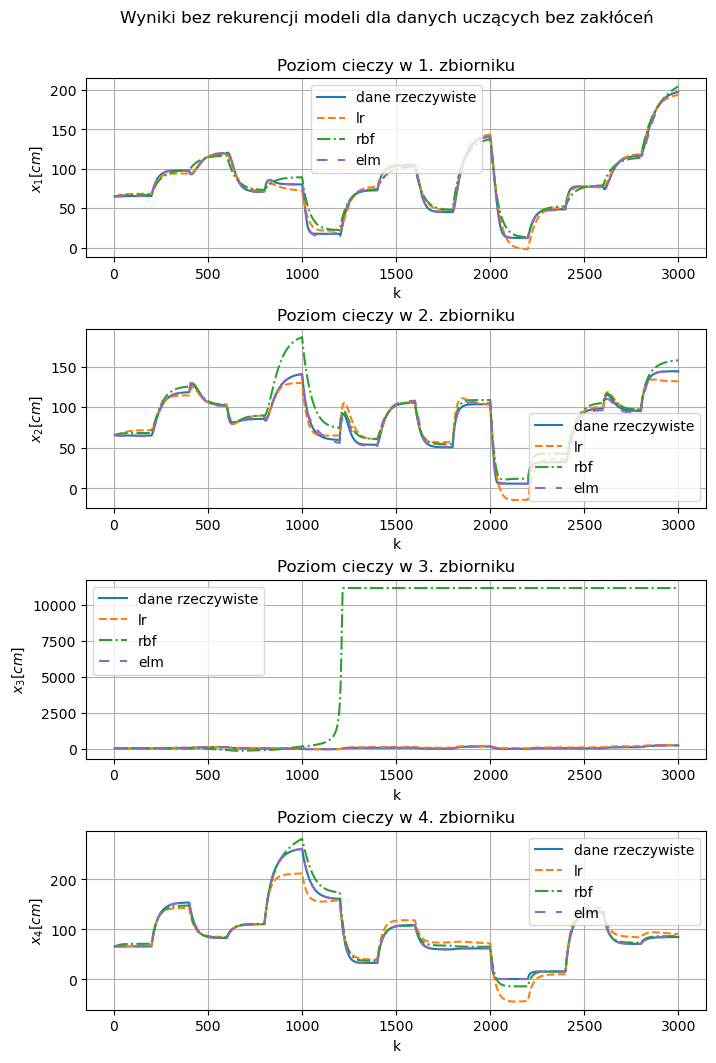

In [154]:
plot_model_result_all_tanks(df_train, dataset_name, "uczących", pred_mode)

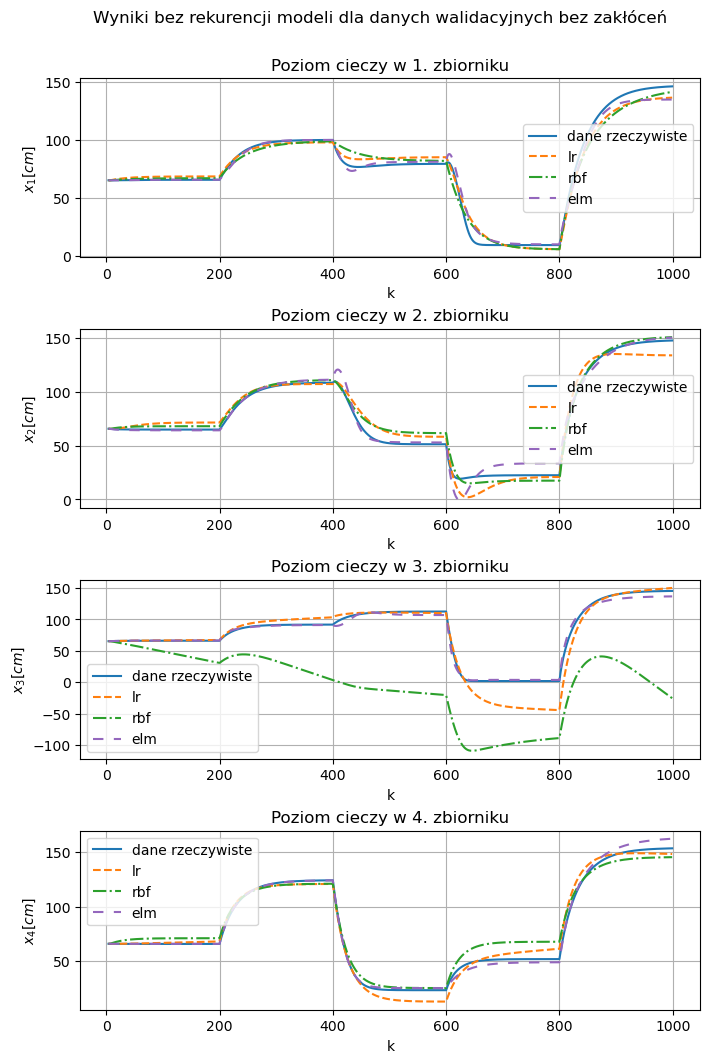

In [155]:
plot_model_result_all_tanks(df_val, dataset_name, "walidacyjnych", pred_mode)

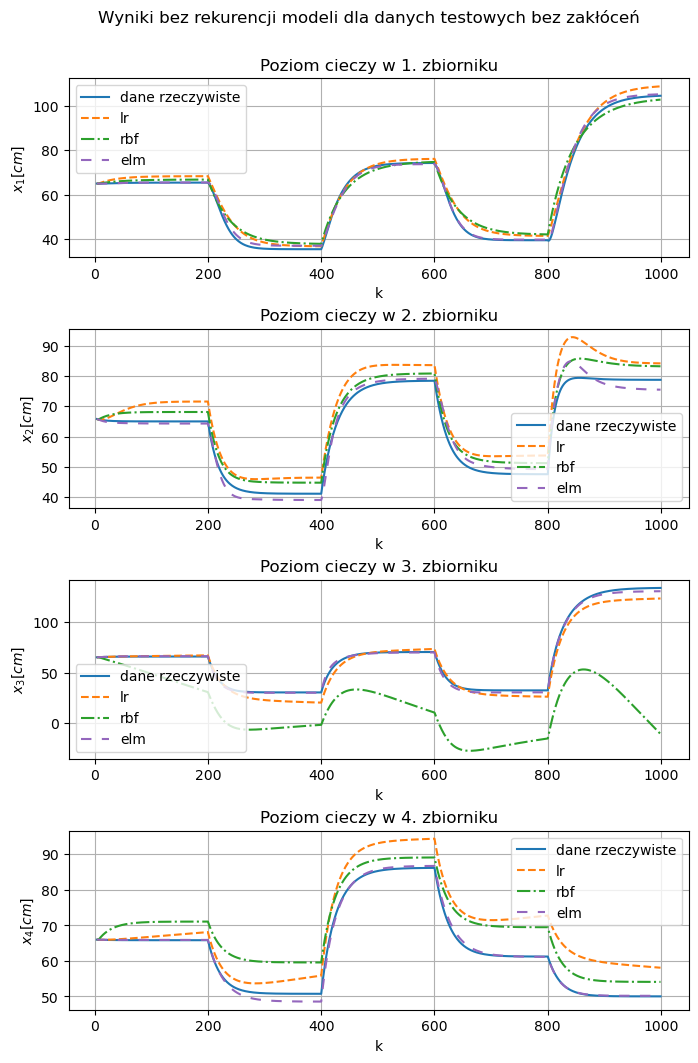

: 

In [156]:
plot_model_result_all_tanks(df_test, dataset_name, "testowych", pred_mode)